# Download the Data

In [1]:
!pip3 install tqdm
!pip3 install pillow --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 20.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pillow
    Found existing installation: pillow 10.2.0
    Uninstalling pillow-10.2.0:
      Successfully uninstalled pillow-10.2.0


In [2]:
%matplotlib inline

import os
import io
import tarfile
import urllib
import shutil
import json
import random
import numpy as np
import boto3
import sagemaker

from tqdm import tqdm
from sagemaker.amazon.amazon_estimator import get_image_uri
from matplotlib import pyplot as plt
from xml.etree import ElementTree as ET
from PIL import Image, ImageDraw, ImageFont

urls = ['http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz',
        'http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz']

def download_and_extract(data_dir, download_dir):
    for url in urls:
        target_file = url.split('/')[-1]
        if target_file not in os.listdir(download_dir):
            print('Downloading', url)
            urllib.request.urlretrieve(url, os.path.join(download_dir, target_file))
            tf = tarfile.open(url.split('/')[-1])
            tf.extractall(data_dir)
        else:
            print('Already downloaded', url)

if not os.path.isdir('data'):
    os.mkdir('data')

download_and_extract('data', '.')

Matplotlib is building the font cache; this may take a moment.


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Visualize Data

In [3]:
# Number of Trimaps in Trimaps folder  

trimaps_dir = 'data/annotations/trimaps/'

maps = [x for x in os.listdir(trimaps_dir) if x[-3:] == 'png']
print(len(maps))

14780


In [4]:
# Number of Images in Images folder 

image_dir = 'data/images/'

images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

7390


In [5]:
# Image filename format

images[0]

'boxer_184.jpg'

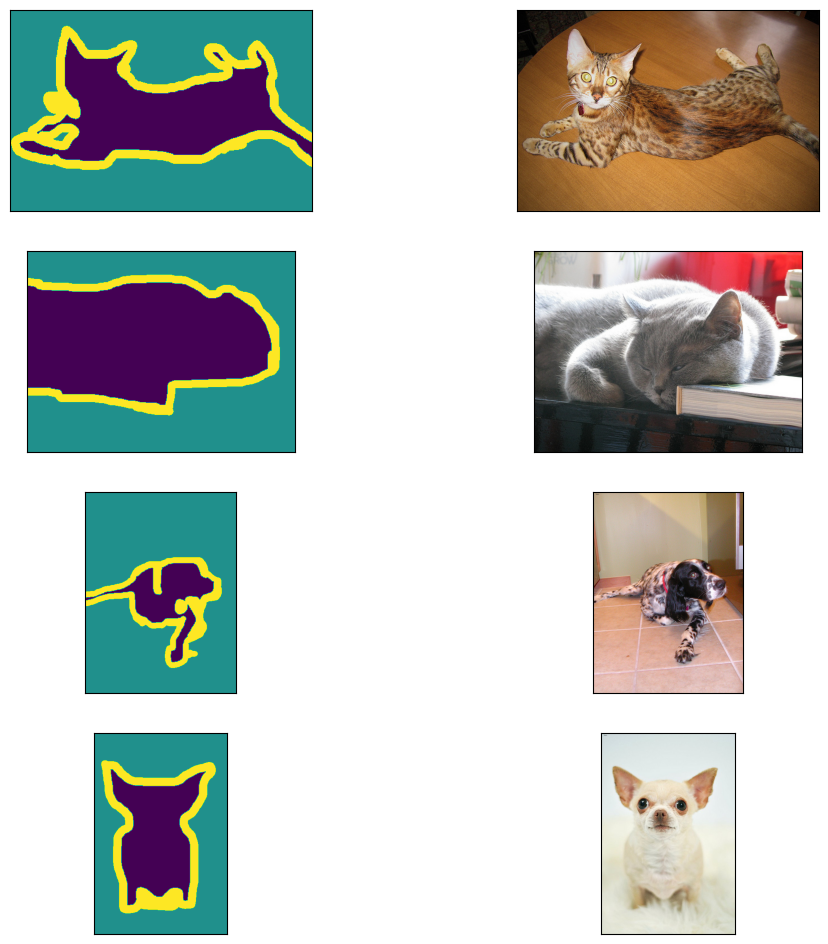

In [6]:
# Plotting some randome images with their corosponding mapping in a 4 * 2 dimension

plt.figure(figsize=(12, 12))

for i in range(0, 4):
    index = random.randint(0, len(images) - 1)
    image_name = images[index]
    map_name = images[index].split('.')[0] + '.png'

    plt.subplot(4, 2, 1 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(trimaps_dir, map_name)))
    plt.subplot(4, 2, 2 + i*2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(plt.imread(os.path.join(image_dir, image_name)))
plt.show()

In [8]:
# Values availabe in these Trimaps at 1, 2, 3 value set 

img = Image.open(os.path.join(trimaps_dir, maps[1]))
print(np.unique(img))

[1 2 3]


# SageMaker Setup

In [21]:
# Building the Sage-Maker Semantic-Segemnetations algorithm 

import boto3
from sagemaker import image_uris 

# Get the SageMaker execution role
role = sagemaker.get_execution_role()

# Your S3 bucket for storing data
bucket_name = 'petsdata12345'  

# Get the correct image URI (note the change in function)
training_image = image_uris.retrieve(framework='semantic-segmentation',  # Use framework argument
                                    region=boto3.Session().region_name, 
                                    version='latest')

print(training_image)

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


825641698319.dkr.ecr.us-east-2.amazonaws.com/semantic-segmentation:1


In [22]:
# Creating 4 folders for Training and validation data sets and training_annotation and validation_annotaion required by sematnic segemtation algorithm 
# the annotaion sets have the ""trimaps"" corosponding to the training and validation images 
folders = ['train', 'train_annotation', 'validation', 'validation_annotation']

for folder in folders:
    if os.path.isdir(folder):
        shutil.rmtree(folder)
    os.mkdir(folder)

# Preparing Data for SageMaker

In [23]:
# Creating the train and validation split for our dataset 

def get_map_file(image):
    map_file = image.split('.')[0] + '.png'
    assert map_file in maps
    return map_file
    
for image in tqdm(images):
    target_set = 'train' if random.randint(0, 99) < 75 else 'validation'
    
    image_file_path = os.path.join('data/images/', image)
    image_target_path = os.path.join(target_set, image)
    
    map_file_path = os.path.join(trimaps_dir, get_map_file(image))
    map_target_path = os.path.join(target_set + '_annotation', get_map_file(image))
    
    shutil.copy(image_file_path, image_target_path)
    shutil.copy(map_file_path, map_target_path)

100%|██████████| 7390/7390 [00:19<00:00, 384.58it/s]


In [24]:
train_images = os.listdir('train')
train_annots = os.listdir('train_annotation')

In [25]:
# Number of Training images and their corrosponding annotaions must match 
print(len(train_annots), len(train_images))

5532 5532


# Uploading Data to S3

In [26]:
# creating sagemmaker session and uploading train and validation data into our assigned s3 bucket 
sess = sagemaker.Session()

# First the training data and its trimap annotaions
print('starting upload')

s3_train_path = sess.upload_data(path='train', bucket=bucket_name, 
                                 key_prefix='train')

print('Training images uploaded')

s3_train_annotation_path = sess.upload_data(path='train_annotation', bucket=bucket_name,
                                            key_prefix='train_annotation')

print('Trainig annotations uploaded')

# Second the validation data and its trimap annotaions

print('starting upload')

s3_validation_path = sess.upload_data(path='validation', bucket=bucket_name, 
                                      key_prefix='validation')

print('Validation images uploaded')

s3_validation_annotation_path = sess.upload_data(path='validation_annotation', bucket=bucket_name, 
                                                 key_prefix='validation_annotation')

print('validation annotaions uploaded')

starting upload
Training images uploaded
Trainig annotations uploaded
starting upload
Validation images uploaded
validation annotaions uploaded


In [27]:
s3_validation_annotation_path

's3://petsdata12345/validation_annotation'

# SageMaker Estimator

In [138]:
# Create the SageMaker estimator 
model = sagemaker.estimator.Estimator(
    training_image,  # Use 'image_uri' instead of 'training_image'
    role=role,
    instance_count=1,         # Renamed 'train_intsance_count' to 'instance_count'
    instance_type='ml.p3.2xlarge', # Use a more cost effective instance type for initial testing
    volume_size=100,          # Renamed 'train_volume_size' to 'volume_size'
    max_run=36000,            # Renamed 'train_max_run' to 'max_run'
    input_mode='File',        # Capitalized 'File' for consistency
    output_path='s3://petsdata12345/output',
    sagemaker_session=sess,
    #use_spot_instances=True,     # Optionally uncomment to use Spot Instances (requires quota)
    #max_wait=None             # Remove or set a maximum wait time if using Spot Instances
)

# Hyperparameters

In [139]:
# Setting Hyperparameters to the Model
model.set_hyperparameters(
    backbone='resnet-50',
    algorithm='fcn',
    use_pretrained_model='True',  # Set to string 'True'
    crop_size=240,
    num_classes=4,
    epochs=10,
    learning_rate=0.0001,         # Fixed typo: 'learinig_rate' to 'learning_rate'
    optimizer='rmsprop',
    lr_scheduler='poly',
    mini_batch_size=16,
    validation_mini_batch_size=16,
    num_training_samples=len(train_images)
)

# Data Channels

In [140]:
# Creating data channels 
s3_train_data = sagemaker.inputs.TrainingInput(s3_train_path, distribution='FullyReplicated', content_type='image/jpeg', s3_data_type='S3Prefix')  # Updated constructor and string 'S3Prefix'

s3_validation_data = sagemaker.inputs.TrainingInput(s3_validation_path, distribution='FullyReplicated', content_type='image/jpeg', s3_data_type='S3Prefix') 

s3_train_annotation_data = sagemaker.inputs.TrainingInput(s3_train_annotation_path, distribution='FullyReplicated', content_type='image/jpeg', s3_data_type='S3Prefix') 

s3_validation_annotation_data = sagemaker.inputs.TrainingInput(s3_validation_annotation_path, distribution='FullyReplicated', content_type='image/jpeg', s3_data_type='S3Prefix')

In [141]:
data_channel = {
    'train': s3_train_data,           # Use the S3Input objects we created earlier
    'validation': s3_validation_data,
    'train_annotation': s3_train_annotation_data,  # Fix typo: 'train_annotaion'
    'validation_annotation': s3_validation_annotation_data # Fix typos: 'validation__annotation' and 'validationn_annotation_data'
}

data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7f64c0150160>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f64c01520b0>,
 'train_annotation': <sagemaker.inputs.TrainingInput at 0x7f64c0151390>,
 'validation_annotation': <sagemaker.inputs.TrainingInput at 0x7f64c01534f0>}

# Model Training

In [142]:
# Start the training job.
model.fit(inputs=data_channel, logs=True)

INFO:sagemaker:Creating training-job with name: semantic-segmentation-2024-06-29-03-01-06-606


ResourceLimitExceeded: An error occurred (ResourceLimitExceeded) when calling the CreateTrainingJob operation: The account-level service limit 'ml.g4dn.xlarge for spot training job usage' is 0 Instances, with current utilization of 0 Instances and a request delta of 1 Instances. Please use AWS Service Quotas to request an increase for this quota. If AWS Service Quotas is not available, contact AWS support to request an increase for this quota.

# Deploy Model

In [131]:
# Deploy the model 
deployed_model = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')
print("\nModel deployed!")

ValueError: Estimator is not associated with a training job

# Predictions

In [132]:
image_dir = 'validation'
images = [x for x in os.listdir(image_dir) if x[-3:] == 'jpg']
print(len(images))

1858


In [133]:
deployed_model.content_type = 'image/jpeg'  # Input content type (JPEG)
deployed_model.accept = 'image/png'       # Output content type (PNG)

NameError: name 'deployed_model' is not defined

In [134]:
index = 2

image_path = os.path.join(image_dir, images[index])
# image_path = 'dog_cat.jfif'

with open(image_path, 'rb') as f:
    b = bytearray(f.read())

results = deployed_model.predict(b)

NameError: name 'deployed_model' is not defined

In [135]:
mask = np.array(Image.open(io.BytesIO(results)))

NameError: name 'results' is not defined

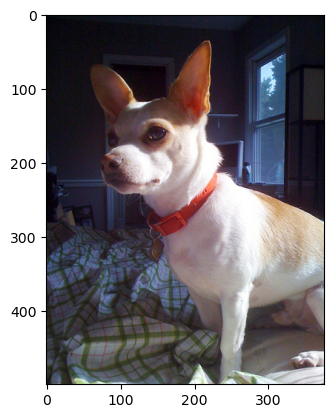

In [136]:
plt.imshow(plt.imread(image_path));

In [137]:
plt.imshow(mask);

NameError: name 'mask' is not defined

Don't forget!! You need to delete endpoint or else you will continue to accrue cost!

In [ ]:
sagemaker.Session().delete_endpoint(deployed_model.endpoint)